In [11]:
import glob
import cv2 # OpenCV
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn
import torchvision
from torchvision import models

import torchvision.utils
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

### Custom Dataset 만들기

#### Train Dataset

In [2]:
root_dir="/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/mvtec/leather/train/good/"

In [3]:
train_file_list = glob.glob(root_dir + "*")

train_data = []

for img_path in train_file_list:
  # Check for problematic images
  img = cv2.imread(img_path, cv2.IMREAD_COLOR)
  if type(img) is np.ndarray:
    if img.size == 0:
      continue
  if img is None:
      continue
  train_data.append([img_path])

print(len(train_data))

[['/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/mvtec/leather/train/good/000.png'], ['/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/mvtec/leather/train/good/002.png'], ['/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/mvtec/leather/train/good/006.png'], ['/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/mvtec/leather/train/good/001.png'], ['/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/mvtec/leather/train/good/004.png'], ['/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/mvtec/leather/train/good/003.png'], ['/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/mvtec/leather/train/good/007.png'], ['/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/mvtec/leather/train/good/005.png'], ['/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/mvtec/leather/train/good/00

In [9]:
train_file_list[:5]

['/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/mvtec/leather/train/good/000.png',
 '/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/mvtec/leather/train/good/002.png',
 '/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/mvtec/leather/train/good/006.png',
 '/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/mvtec/leather/train/good/001.png',
 '/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/mvtec/leather/train/good/004.png']

(1024, 1024)

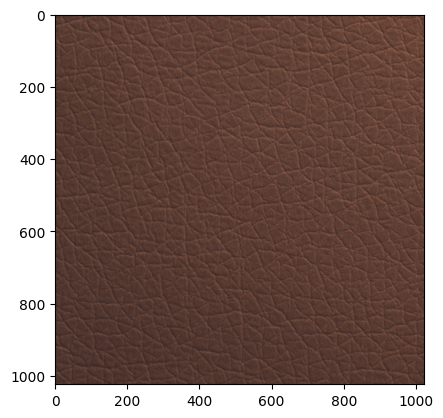

In [17]:
from PIL import Image

img = Image.open('/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/mvtec/leather/train/good/000.png')
plt.imshow(img)
img.size

In [35]:
img = cv2.imread('/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/mvtec/leather/train/good/000.png', cv2.IMREAD_COLOR)
img.shape

(1024, 1024, 3)

In [31]:
class Customtrain(Dataset):

    def __init__(self, data, transform=transforms.ToTensor()):
        self.data = data
        # Set image dimensions
        self.img_dim = (1024, 1024)
        # Perform any transformations
        self.transform = transform

    def __len__(self):
        return len(self.data)

    # This function is called when an element of this class is accessed via dataset[index]
    def __getitem__(self, index):
        # Get image path and class name
        img_path = self.data[index] # tuple from __init__()
        img_path = img_path[0]
        # Obtain the image from its path and resize it to the required dimension
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, self.img_dim)
        pil_img=Image.fromarray(img) # convert ndarray to PIL
        # Perform transforms if there are any
        if self.transform:
            img_tensor = self.transform(pil_img)

        return img_tensor

In [32]:
trainset = Customtrain(train_data)

train_loader = DataLoader(trainset, batch_size=24,
                          shuffle=True, num_workers=2, pin_memory=True)

In [34]:
batch = next(iter(train_loader))

images = batch

print(images.shape)

torch.Size([24, 3, 1024, 1024])


#### Test Dataset

In [36]:
root_dir = "/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/mvtec/leather/test/"

# Retrieve the list of ALL folders and files inside the base folder
test_file_list = glob.glob(root_dir + "*")

test_data = []
# Create a list that would contain the paths to all the images in the dataset
for class_path in test_file_list:
    class_name = class_path.split("/")[-1] # extract the class name, e.g.
    # Retrieve each image in their folders (i.e. 0.jpg, 1.jpg, etc.)
    for img_path in glob.glob(class_path + "/*.png"):
        # Check for problematic images
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if type(img) is np.ndarray:
          if img.size == 0:
            continue
        if img is None:
            continue
        test_data.append([img_path, class_name]) # append image file path to init_data list, and its class name

print(len(test_data))

[['/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/mvtec/leather/test/poke/001.png', 'poke'], ['/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/mvtec/leather/test/poke/004.png', 'poke'], ['/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/mvtec/leather/test/poke/002.png', 'poke'], ['/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/mvtec/leather/test/poke/003.png', 'poke'], ['/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/mvtec/leather/test/poke/000.png', 'poke'], ['/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/mvtec/leather/test/poke/012.png', 'poke'], ['/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/mvtec/leather/test/poke/007.png', 'poke'], ['/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/mvtec/leather/test/poke/011.png', 'poke'], ['/content/drive/MyDrive/SW 전문 인재 양성

In [37]:
class CustomCatDog(Dataset):

    def __init__(self, data, transform=transforms.ToTensor()):
        self.data = data
        # Dictionary containing mapping between string and number (class label)
        self.class_map = {"color" : 0, "cut": 1,"fold":2, "glue":3, "good":4, "poke":5}
        # Set image dimensions
        self.img_dim = (1024, 1024)
        # Perform any transformations
        self.transform = transform

    def __len__(self):
        return len(self.data)

    # This function is called when an element of this class is accessed via dataset[index]
    def __getitem__(self, index):
        # Get image path and class name
        img_path, class_name = self.data[index] # tuple from __init__()
        # Obtain the image from its path and resize it to the required dimension
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, self.img_dim)
        class_id = self.class_map[class_name] # get the class label, e.g. 0 (for "Dog")
        pil_img=Image.fromarray(img) # convert ndarray to PIL
        # Perform transforms if there are any
        if self.transform:
            img_tensor = self.transform(pil_img)
        # Convert class label to a tensor
        class_id = torch.tensor(class_id)

        return img_tensor, class_id

In [38]:
testset = CustomCatDog(test_data)

test_loader = DataLoader(testset, batch_size=24,
                          shuffle=False, num_workers=2, pin_memory=True)

In [39]:
batch = next(iter(test_loader))

images, labels = batch

print(images.shape)

torch.Size([24, 3, 1024, 1024])
